# Individual Assignment - Classification

**----- Import all libraries here -----**

In [2]:
# data manipulation
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import copy


# visualiation
import matplotlib.pyplot as plt
import seaborn as sb

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgbm

# metrics
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from collections import Counter
from imblearn.over_sampling import SMOTE
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data Analysis 

<span style="color:blue">Load the CSV file into a *DataFrame* object named **pima** using Pandas to examine the dataset and perform data cleaning:</span>
    
<span style="color:blue">1) Print the dtype of each column to review the data types of the attributes in the dataset. *(2 points)*</span>

In [3]:
# --- Your code here ---
pd.set_option('display.max_columns', 500)
pima = pd.read_csv('diabetes.csv')
pima.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure               float64
SkinThickness               float64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

<span style="color:blue">2) Are there any missing values in the dataset? Print out the total count of missing values for the attributes in the dataset. How would you handle the missing values without deleting any record? Develop and execute an operation for that purpose accordingly. *(3 points)*</span>

In [4]:
# --- Your code here ---
print("The Number of missing values in the original dataset:")
print(pima.isnull().sum())

pima[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] =  pima[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)
print("The Number of missing values after processing:")
print(pima.isnull().sum())


The Number of missing values in the original dataset:
Pregnancies                 0
Glucose                     0
BloodPressure               1
SkinThickness               1
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    1
Age                         0
Outcome                     0
dtype: int64
The Number of missing values after processing:
Pregnancies                   0
Glucose                       5
BloodPressure                36
SkinThickness               228
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      1
Age                           0
Outcome                       0
dtype: int64


<span style="color:blue">--- Your answer here ---</span>



<span style="color:black">在原始数据集中,共有三个缺失值。此外，对于[Glucose, BloodPressure, SkinThickness, Insulin, BMI]这五个特征，存在数值0是不合理的，所以这里将其都改为NaN，一并处理，由上输出结果可以看出共约有六百多缺失值。<br>
这里使用均值替代缺失值，代码如下： </span>

In [6]:
# use KNN handle the missing values
for i in [0,1]:
    tmp_row = pima[pima['Outcome'].isin([i])]
    exec("pima_label%s = tmp_row"%i)
for c in pima_label0.columns:
    pima_label0[c].fillna(pima_label0[c].mean(), inplace=True)
for c in pima_label1.columns:
    pima_label1[c].fillna(pima_label1[c].mean(), inplace=True)
pima = pima_label1.append(pima_label0)
pima = pima.sort_index(ascending=True)

pima.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<span style="color:blue">3) Examine Outcome by generating a bar plot showing the count of “0” and “1” in Outcome. Write down any of your insights from observing the bar plot. *(3 points)*</span>

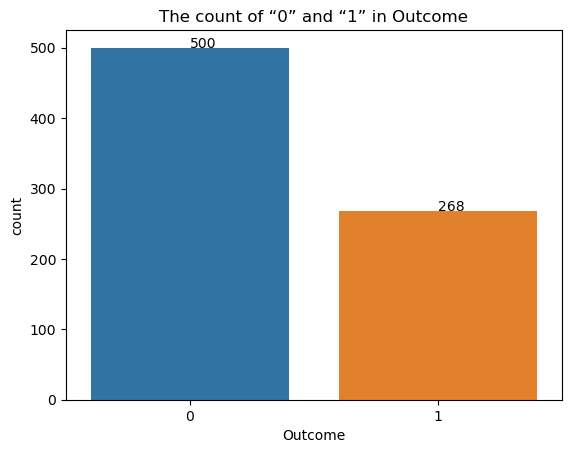

In [7]:
# --- Your code here ---
sb.countplot(x = pima.Outcome)
plt.title("The count of “0” and “1” in Outcome")
plt.text(0,500,500)
plt.text(1,268,268)
plt.show()

<span style="color:blue">--- Your answer here ---</span>


<span style="color:black"> 在观察完柱状图后，我发现：Outcome中 0 的数量几乎是 1 的二倍，这表明该数据存在不平衡的情况。</span>

<span style="color:blue">4) Generate a pairwise relationship scatterplot (8x8 subplots) using __sb.pairplot(pima, vars=feature_column_names, hue='Outcome')__. *(2 points)*</span>

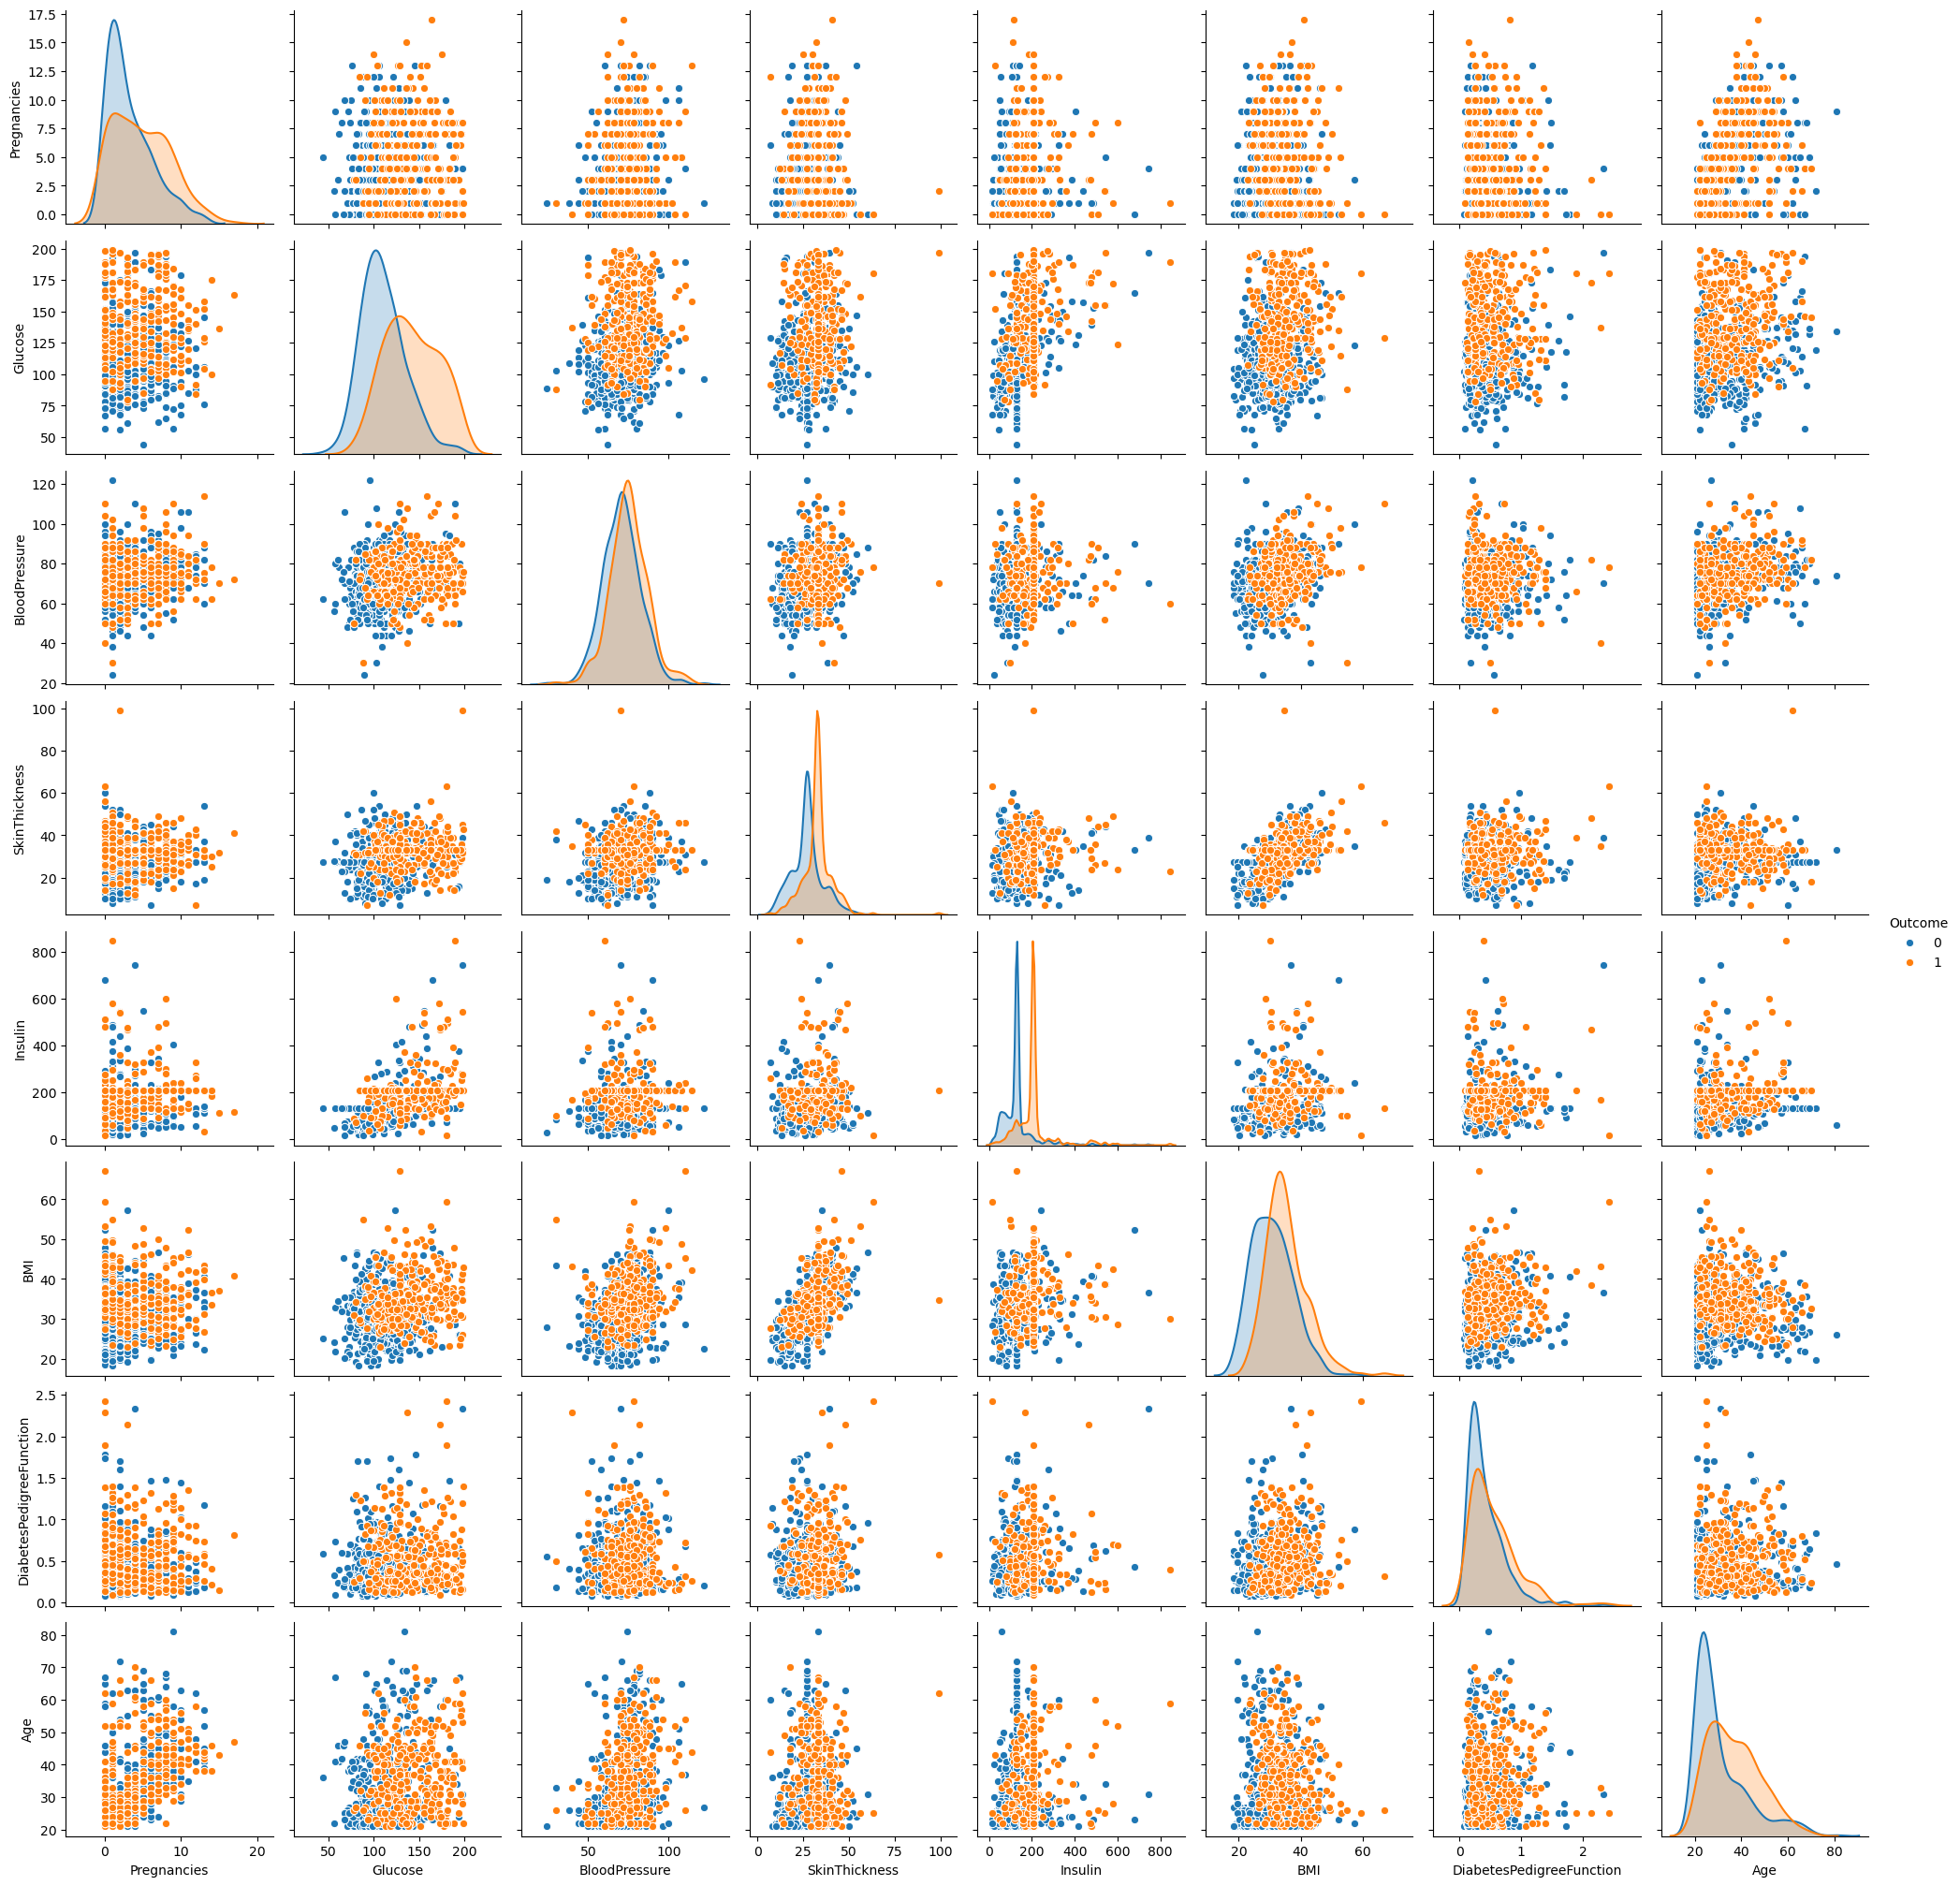

In [8]:
# --- Your code here ---
sb.pairplot(pima, vars = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'], hue = 'Outcome')
plt.show()

<span style="color:blue">5) Generate a 9x9 heatmap plot showing the co-variance between any two features (including target). *(2 points)*<br/>
    
<span style="color:blue">_(Hint: use __sb.clustermap(pima.corr(), annot=True)__ to plot co-variance heatmap.)_</span>

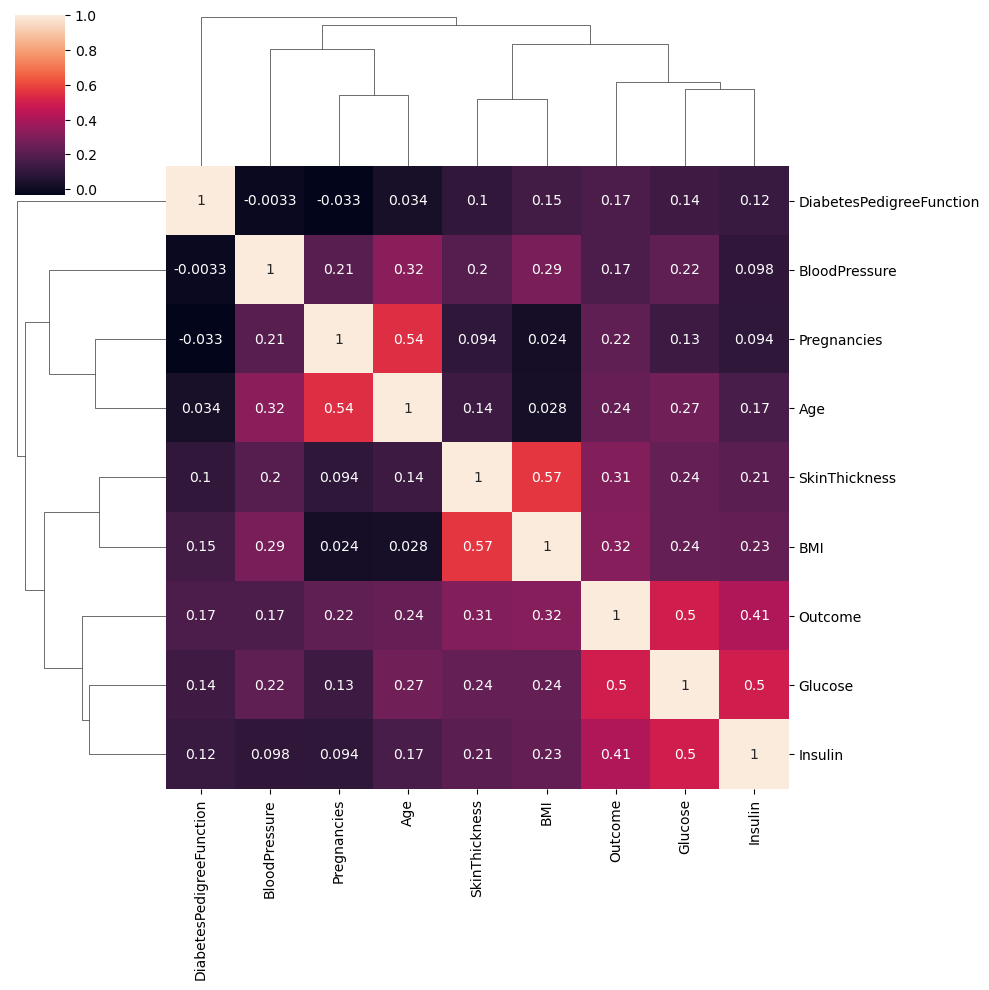

In [9]:
# --- Your code here ---
sb.clustermap(pima.corr(),annot=True) 
plt.show()

<span style="color:blue">6) What are the insights you gained from the two plots generated from 4) and 5)? *(3 points)*</span>

<span style="color:blue">_(Hint: think about how to perform feature selection based on the observations, which may be helpful for constructing your best model in Section 4.)_</span>

<span style="color:blue">--- Your answer here ---</span>

<span style="color:black"> 从4）和5）的图中可以看出各个属性两两之间的关联性，比如在4）中我们看到，BMI和SkinThickness之间更明显有呈现线性相关的趋势，而在图5）中就印证了我们的这个想法，这两个属性的相关性最大。此外还有很多相似的结论可以从图中得出。</span>

# 2. Feature Transformation

We observe that all the variables in the dataset except the target variable *Outcome* are continuous. In this section, you will perform feature transformation on the continuous variables to generate two sets of features that will be used in the subsequent classification task.

**Feature set 1 - Continuous to Categorical**

<span style="color:blue">1) Often when dealing with continuous variables like *BMI* or *BloodPressure*,  we may wish  to transform these continuous variables into categorical variables, which may be better predictors of *Outcome*. This transformation can be achieved as follows: cut the continuous values of each feature into non-overlapping buckets.  Perform this operation on all 8 continuous variables.  You are to devise you own method to cut the continuous values into buckets. Name the resulting DataFrame as __pima1__. pima1 should still contains 9 conlumns with the same set of column names as pima. Use **pima1.head()** to show the top rows. *(5 points)*</span>
    
<span style="color:blue">*(Hint: you can use **pandas.cut()** or **pandas.qcut()** to convert continuous feature to categorical feature. e.g. For Glucose, if you wish to adopt the glucose level guidelines given by American Diabetes Association, you can convert its values into 3 groups:<br/>*
*- Normal > 140mg/dl of glucose,<br/>*
*- Prediabete 140-199mg/dl of glucose,<br/>*
*- Diabetes > 200mg/dl of glucose<br/>*
*using  **pd.cut(pima[’Glucose’],[50,139.99,199.99,250], labels=[0, 1, 2])**. Or you can use **pd.qcut(pima[’Glucose’],4, labels=[0,1,2,3])** to cut the values according to quantile-based discretization function.)*
</span>

In [10]:
# --- Your code here ---
pima1 = pima.copy(deep=True)
for column in pima.columns:
        pima1[column] = pd.qcut(pima1[column].rank(method='first'),4,labels=[0,1,2,3])
pima1['Glucose'] = pd.cut(pima['Glucose'],[50,139.99,199.99,250], labels=[0,1,2])
pima1['BMI'] = pd.cut(pima['BMI'],[0,18.5,25,70], labels=[0,1,2])
pima1['Outcome'] = pima['Outcome']
pima1.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,1,1,3,2,2,3,3,1
1,0,0,1,2,1,2,1,2,0
2,3,1,0,2,2,1,3,2,1
3,0,0,1,0,0,2,0,0,0
4,0,0,0,3,2,2,3,2,1


<span style="color:blue">2) Next, we convert the generated categorical features into binary features using the **one-hot encoding scheme**. Assume the continuous feature has m numerical labels. The one-hot encoding scheme will results in a vector of size m with only one of the values as 1 (indicating it as active). Use **pima1.head()** to show the top rows of the encoded pima1. *(2 points)*</span>

<span style="color:blue">*(Hint: you can use **pd.getdummies()** to convert each categorical feature in pima1 into multiple binary features.)*</span>

In [11]:
# --- Your code here ---
pima1 = pd.get_dummies(pima1, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
pima1.head()

,Outcome,Pregnancies_0,Pregnancies_1,Pregnancies_2,Pregnancies_3,Glucose_0,Glucose_1,Glucose_2,BloodPressure_0,BloodPressure_1,BloodPressure_2,BloodPressure_3,SkinThickness_0,SkinThickness_1,SkinThickness_2,SkinThickness_3,Insulin_0,Insulin_1,Insulin_2,Insulin_3,BMI_0,BMI_1,BMI_2,DiabetesPedigreeFunction_0,DiabetesPedigreeFunction_1,DiabetesPedigreeFunction_2,DiabetesPedigreeFunction_3,Age_0,Age_1,Age_2,Age_3
0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0
2,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0
4,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0


<span style="color:blue">3) Discuss whether the use of one-hot encoding can be omitted and why? *(3 points)*</span>

<span style="color:blue">--- Your answer here ---</span>


<span style="color:black"> one-hot编码在这里不能省去，因为我们前面对数据进行了分类，分为[0, 1, 2,..., n]，这对于机器来说，会有数值大小的概念，虽然我们知道不同的数字只是类别区分，不具有可比较的意义，但是机器不知道，所以要使用one-hot编码进行进一步的处理。</span>

**Feature set 2 - Features normalization**

<span style="color:blue">4) For the second feature set, we normalize the values of 8 continuous variables. For each variable, we apply the transformation using the formula **z=(x−u)/s**, where u and s are the mean and standard deviation of the variable values. Name the resulting DataFrame as **pima2**, and show the top rows using pima2.head(). *(2 points)*</span>

<span style="color:blue">*(Hint: you can use **StandardScaler** from scikit-learn for standadization purpose)*</span>

In [12]:
# --- Your code here ---
ss = StandardScaler()
pima2 = ss.fit_transform(pima)
pima2 = pd.DataFrame(pima2)
pima2.columns = pima.columns
pima2['Outcome'] = pima['Outcome']

pima2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.864020,-0.036867,0.645607,0.561272,0.167806,0.469687,1.425995,1
1,-0.844885,-1.205478,-0.533269,-0.027139,-0.300842,-0.850452,-0.364111,-0.190672,0
2,1.233880,2.013741,-0.698736,0.421359,0.561272,-1.330487,0.605632,-0.105584,1
3,-0.844885,-1.074081,-0.533269,-0.699885,-0.709475,-0.632253,-0.919975,-1.041549,0
4,-1.141852,0.502679,-2.684344,0.645607,0.123830,1.549727,5.487576,-0.020496,1


<span style="color:blue">5) Briefly discuss whether Feature set 1 or Feature set 2 is more useful for training classification models and why? Also comment on whether feature normalization is necessary in this case. *(3 points)*</span>

<span style="color:blue">--- Your answer here ---</span>

<span style="color:black">我认为特征集pima2对训练更有用，因为独热编码的特征数量较多，而且即使没有独热编码，仍然可以在集2中计算距离。<br>
我认为特征归一化是必要的，因为在这种情况下，单位在特征之间是不同的。我们需要对特征进行归一化，以消除特征之间单位和尺度差异的影响。</span>

# 3. Model Construction

Your task in this section is to use the derived feature sets from previous section to construct classification models for diabetes outcome prediction (0 or 1).  We have splitted the data into training and test sets for you as shown below (you need to run the cell below).

In [13]:
# pima1 split
# Feature set 1
x1 = pima1.drop(columns='Outcome')
y1 = pima1['Outcome']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

# pima2 split
# Feature set 2
x2 = pima2.drop(columns='Outcome')
y2 = pima2['Outcome']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

print(x1.shape, y1.shape)
print(x2.shape, y2.shape)

(768, 30) (768,)
(768, 8) (768,)


<span style="color:blue">1) Experiment with the 5 classification models below from scikit-learn with their default hyperparameter settings on pima1 and pima2 (You should thus perform 5x2 times model training and evaluation):<br/></span>

<span style="color:blue">- Gaussian naive bayes</span><br/>
<span style="color:blue">- KNN</span><br/>
<span style="color:blue">- SVM</span><br/>
<span style="color:blue">- logistic regression</span><br/>
<span style="color:blue">- decision tree<br/></span>
    
<span style="color:blue">You should perform model training on x_train1 and x_train2,  and perform evaluation on x_test1 and x_test2 respectively.  Use **accuracy** and **weighted F1** as evaluation metrics, and save the results of different models in the defined lists **pima1_acc**, **pima2_acc**, **pima1_f1**, **pima2_f1**. Note that the order of results in each list should match the model order provided in **model_names**. Print the **accuracy_record** table and **F1_record** table using the provided code. *(20 points)*</span>

In [14]:
model_names = ['Gaussian NB', 'KNN', 'SVM', 'LR', 'DT']
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

# --- Your code here ---
models = []
models.append(GaussianNB())  # 高斯贝叶斯
models.append(KNeighborsClassifier())  #KNN
models.append(SVC())  # 支持向量机
models.append(LogisticRegression())  #逻辑回归
models.append(DecisionTreeClassifier())  #决策树

for model in models:
    model.fit(x_train1, y_train1)
    y_pred1 = model.predict(x_test1)
    pima1_acc.append(metrics.accuracy_score(y_test1, y_pred1))
    pima1_f1.append(metrics.f1_score(y_test1, y_pred1))

for model in models: 
    model.fit(x_train2, y_train2)
    y_pred2 = model.predict(x_test2)
    pima2_acc.append(metrics.accuracy_score(y_test2, y_pred2))
    pima2_f1.append(metrics.f1_score(y_test2, y_pred2))

pima1_acc = pd.DataFrame(pima1_acc).T
pima2_acc = pd.DataFrame(pima2_acc).T
acc = pima1_acc.append(pima2_acc)
acc.columns = model_names
acc.index = ['pima1_acc', 'pima2_acc']

pima1_f1 = pd.DataFrame(pima1_f1).T
pima2_f1 = pd.DataFrame(pima2_f1).T
f1 = pima1_f1.append(pima2_f1)
f1.columns = model_names
f1.index = ['pima1_f1', 'pima2_f1']


acc_f1 = acc.append(f1)
acc_f1.columns = model_names
acc_f1.index = ['pima1_acc', 'pima2_acc','pima1_f1', 'pima2_f1']

In [17]:
# acc
# f1
acc_f1

,Gaussian NB,KNN,SVM,LR,DT
pima1_acc,0.630208,0.843750,0.859375,0.880208,0.781250
pima2_acc,0.802083,0.843750,0.838542,0.786458,0.875000
pima1_f1,0.628272,0.754098,0.780488,0.824427,0.671875
pima2_f1,0.672414,0.761905,0.743802,0.630631,0.803279


<span style="color:blue">2) According to the results above, which feature set is better, pima1 or pima2? Select one to be used in the following tasks. *(2 points)*</span>

<span style="color:blue">--- Your answer ---</span>


<span style="color:black">根据表中数据可以看出，pima2更好。 </span>

<span style="color:blue">3) Select one classification model from 1). Discuss which are the hyperparameters that may affect the model performance the most. Perform grid search with 10 folds cross-validation for tuning those hyperparameters on the training set of either pima1 or pima2 (according to your choice in 2)), using accuracy as the scoring metric. Print the configuration of the best selected model and its prediction **accuracy** and **weighted F1** scores on the corresponding test set. *(15 points)*</span>

<span style="color:blue">*(Hint: for each selected hyperparameter, you need to prepare a list of reasonable values for tunining. Use **sklearn.model_selection.GridSearchCV** for grid search.)*</span>

<span style="color:blue">--- Your choice of hyperparameters here ---</span>


<span style="color:black">选择的模型为KNN，需要调整的超参数为：weights, n_neighbors, p </span>

In [18]:
# --- Your code here ---
kfold = StratifiedKFold(n_splits = 10)
knn_param_grid = [{'weights':['uniform'], 'n_neighbors':[i for i in range(1,100)]}, {'weights':['distance'], 'n_neighbors':[i for i in range(1,100)], 'p':[i for i in range(1,6)]}]
grid = GridSearchCV(KNeighborsClassifier(), param_grid = knn_param_grid, cv = kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
grid.fit(x_train2, y_train2)
print(grid.best_params_)
y_grid_pred = grid.best_estimator_.predict(x_test2)
print('acc: ', metrics.accuracy_score(y_test2, y_grid_pred))
print('f1: ', metrics.f1_score(y_test2, y_grid_pred))

Fitting 10 folds for each of 594 candidates, totalling 5940 fits
{'n_neighbors': 22, 'p': 1, 'weights': 'distance'}
acc:  0.8802083333333334
f1:  0.8067226890756302


<span style="color:blue">4) Besides accuracy and F1 scores, one can look at the confusion matrix to understand the model's prediction behaviour. Compare confusion matrix on test data before and after hyperparameter tuning for the selected model in 3). Discuss any of your observations or insights. *(5 points)*</span>

<span style="color:blue">*(Hint: you can use **confusion_matrix** from scikit-learn, and use **sb.heatmap(conf_matrix, annot=True)** to plot a corresponding heatmap for better visualization.)*</span>

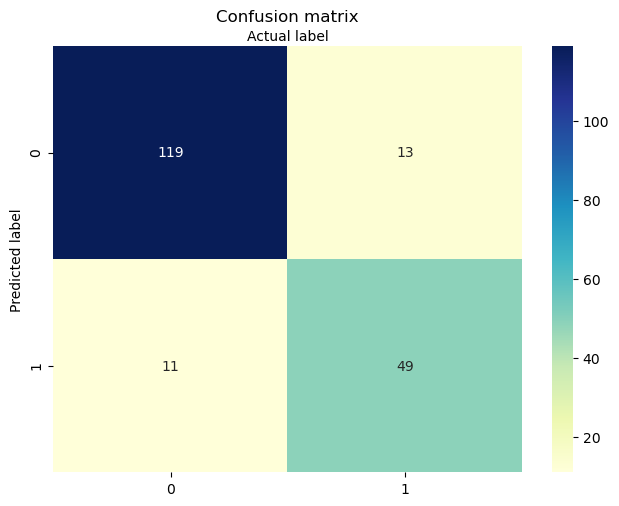

In [19]:
# --- Your code here ---
matrix_before = metrics.confusion_matrix(y_pred2, y_test2)
matrix_after = metrics.confusion_matrix(y_grid_pred, y_test2)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sb.heatmap(pd.DataFrame(matrix_before), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.show()

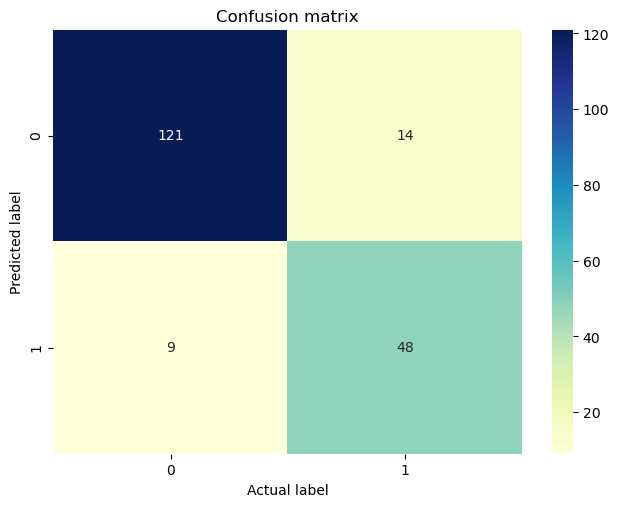

In [20]:
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sb.heatmap(pd.DataFrame(matrix_after), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.show()

<span style="color:blue">--- Your observations here ---</span>

<span style="color:black">通过对比两个混淆矩阵可以看到，正确归类的数量从 119+49 增长到 121+48，这说明经过超参数调优后，模型性能确实提升了。</span>

<span style="color:blue">5) You can get feature importances for some tree-based classifiers in scikit-learn via **clf.feature_importances_**. Example code for plotting pima2 feature importances for an adaboost decision tree classifier has been given below. Generate the plot and describe your observations. Briefly describe how the feature importances for the given classifier can be computed. *(5 points)*</span>

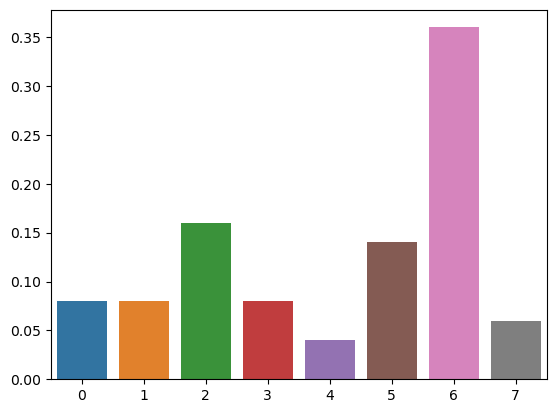

In [21]:
x_train = x_train2
y_train = y_train2

ada = AdaBoostClassifier(random_state=0)
ada.fit(x_train, y_train)
relevants = ada.feature_importances_
indices = np.argsort(relevants)[::-1]

# --- Your code here ---
# Plot feature importances
feature_plotX = indices
feature_plotY = relevants
sb.barplot(feature_plotX, feature_plotY)
plt.show()

<span style="color:blue">--- Your description here ---</span>

<span style="color:black">从图中可以看出，第六个特征（DiabetesPedigreeFunction）最重要的分类特征。
<br>
对于adaBoost分类器，特征重要性的计算是基于每个树中的每个节点的基尼值和加权样本数。
 </span>

<span style="color:blue">6)  Think  about  how  to  compute  the  feature  importances  for  other  classifiers  in  1).   Select  one classifier (except decsion tree), and generate a similar bar plot showing the feature importances. *(8 points)*</span>

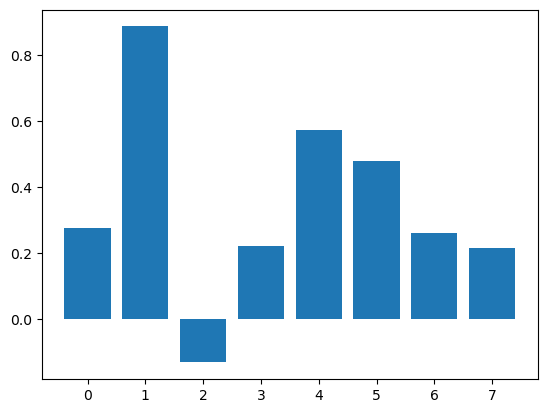

In [29]:
# --- Your code here ---
lr = LogisticRegression()
lr.fit(x_train, y_train)
f_importance = lr.coef_[0]
plt.bar([x_train for x_train in range(len(f_importance))], f_importance)
plt.show()

# 4. Best Model Construction

<span style="color:blue">1) Generate the best classifier you can for predicting the diabetes outcome. Show the classification **accuracy**, **weighted F1** and **confusion matrix** on test data (you should keep the original train test split). Besides that, you can also show any result or plot that are helpful for us to better understand your model. Write a short description of you model indicating the elements that help to improve prediction. You may use any classifier including but not limited to those experimented above. Marks will be given based on your model performance and description. *(13 points)*</span>

<span style="color:blue">*(Hint: you can think about improving the model performance from different aspects: e.g. improve the feature set; choose a more sophisticated classifier such as ensemble models; or improve the training process via careful hyperparameter tunning or sampling techniques.)*</span>

<span style="color:blue">--- Your description here ---</span>

<span style="color:black"> 首先使用SMOTE对数据进行过采样。<br>
其次，因为pima2在DT上的结果更好，所以这里选择基于DT的LGBM模型。并通过调整超参数优化结果。 </span>

In [24]:
x_train2.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [25]:
# --- Your code here ---
# over sampling
print("Before oversampling: "+ str(Counter(y_train2)))
smo = SMOTE(random_state=42)
x_smo_train, y_smo_train = smo.fit_resample(x_train2, y_train2)
print("After oversampling: "+ str(Counter(y_smo_train)))

Before oversampling: Counter({0: 370, 1: 206})
After oversampling: Counter({0: 370, 1: 370})


<span style="color:blue">--- Your description here ---</span>

<span style="color:black">
从上面的结果可以看到，DT在pima2上的结果最好，所以下面选择了基于DT的LGBM <br>
然后使用RandomizedSearchCV选择最优参数并输出。
</span>

In [27]:
# --- Your code here ---
# tuning
# lunch the search
random_state = 42
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)

n_iter = 300
fit_params = {"early_stopping_rounds" : 100, "eval_metric" : 'auc', "eval_set" : [(x_smo_train,y_smo_train)],'eval_names': ['valid'],'verbose': 0,'categorical_feature': 'auto'}
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4], 'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000], 'num_leaves': sp_randint(6, 50), 'min_child_samples': sp_randint(100, 500), 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 'subsample': sp_uniform(loc=0.2, scale=0.8), 'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7], 'colsample_bytree': sp_uniform(loc=0.4, scale=0.6), 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100], 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

grid_search_lgbm = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=param_test, n_iter=n_iter, scoring='accuracy', cv=5, refit=True, random_state=random_state, verbose=True)
grid_search_lgbm.fit(x_smo_train, y_smo_train, **fit_params)
opt_parameters =  grid_search_lgbm.best_params_
print("Best parameters: " + str(opt_parameters))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters: {'colsample_bytree': 0.6915230555117954, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 126, 'min_child_weight': 0.01, 'n_estimators': 1000, 'num_leaves': 21, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.772920539378555}


LGBM acc: 0.9166666666666666
LGBM f1: 0.8787878787878788


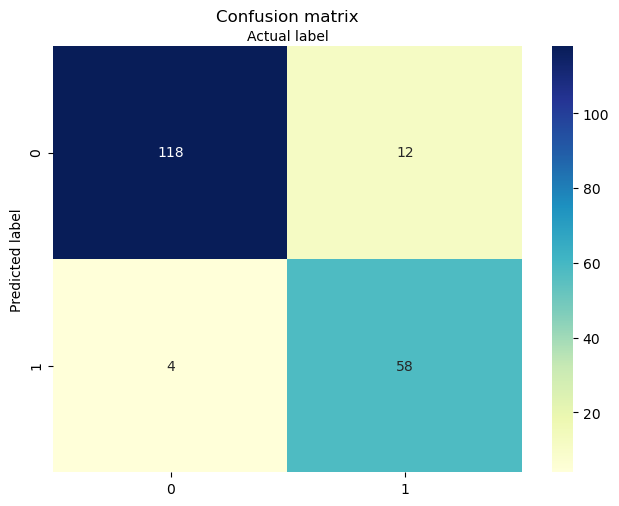

In [33]:
# --- Your code here ---
# best model
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)
lgbm_clf.fit(x_smo_train,y_smo_train)
lgbm_pred = lgbm_clf.predict(x_test2)
lgbm_acc = metrics.accuracy_score(y_test2, lgbm_pred)
lgbm_f1 = metrics.f1_score(y_test2, lgbm_pred)
print("LGBM acc: " + str(lgbm_acc))
print("LGBM f1: " + str(lgbm_f1))

# visualization
confusion_m3 = metrics.confusion_matrix(y_test2, lgbm_pred)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sb.heatmap(confusion_m3, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.xlabel('Actual label')
plt.ylabel('Predicted label')
plt.show()

<span style="color:blue">--- Your description here ---</span>

<span style="color:black"> 使用参数优化后的LGBM进行训练和测试，可以看到最后得到的acc和f1值都比之前得到的要更好。之后在使用混淆矩阵可视化结果，可以看到118+58被正确分类的结果，比之前都要多。</span>

<span style="color:blue">2) Can the final model you constructed be deployed at the hospital to diagnose patients automatically?  How would the doctors explain the prediction results to the patients?  Write down any of your opinions or concerns. *(2 points)*</span>

<span style="color:blue">--- Your opinion here ---</span>

<span style="color:black"> 我认为该模型不可以部署在医院自动诊断病人，因为有关人体病症的判断结果不能接受有误差，更何况是接近10%的误差。<br>
这种预测模型只能作为提高诊断效率的辅助工具，而不可直接作为诊断结果，最终的结果应该由医生进行诊断。<br>
</span>